In [1]:
from efficientnet_pytorch import EfficientNet

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *

In [4]:
model = EfficientNet.from_name('efficientnet-b5')

In [5]:
model_name = 'efficientnet-b5'
image_size = EfficientNet.get_image_size(model_name)

In [6]:
image_size

456

In [7]:
model = EfficientNet.from_pretrained(model_name)


Loaded pretrained weights for efficientnet-b5


In [8]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [9]:
np.random.seed(13)


In [10]:
import os
test_file_location = os.getcwd()+'/test-snakes-cropped'

In [11]:
src = (ImageList.from_folder(path='fastai-data').split_by_rand_pct(0.2).label_from_folder())

In [12]:
src.add_test_folder(test_file_location)

LabelLists;

Train: LabelList (65932 items)
x: ImageList
Image (3, 110, 268),Image (3, 189, 175),Image (3, 232, 405),Image (3, 622, 203),Image (3, 174, 191)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: fastai-data;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 195, 582),Image (3, 236, 288),Image (3, 133, 388),Image (3, 556, 934),Image (3, 271, 164)
y: CategoryList
class-204,class-639,class-337,class-508,class-771
Path: fastai-data;

Test: LabelList (17686 items)
x: ImageList
Image (3, 202, 166),Image (3, 211, 362),Image (3, 367, 563),Image (3, 902, 678),Image (3, 1204, 897)
y: EmptyLabelList
,,,,
Path: fastai-data

In [13]:
tfms=([rotate(degrees=(-90,90), p=0.8)],[])

In [14]:
bs=8

In [15]:
data = (src.transform(tfms, size=image_size, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs).normalize(imagenet_stats))

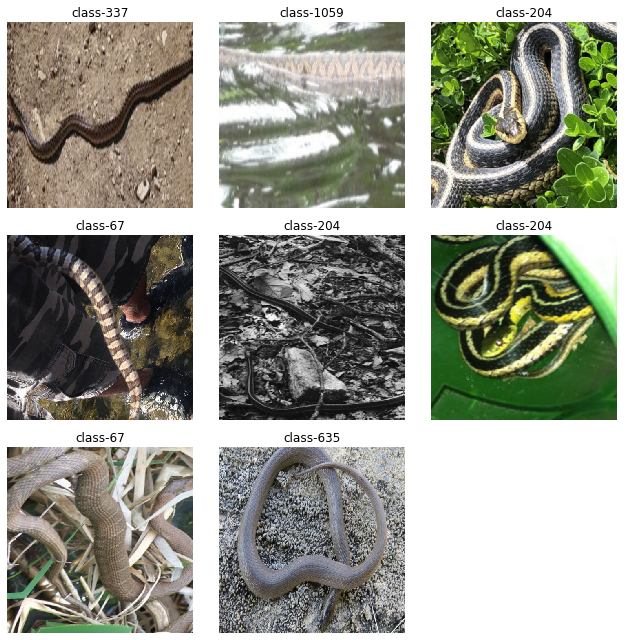

In [16]:
data.show_batch(3,figsize=(9,9))

In [17]:
list(children(model))[-2:]


[BatchNorm2d(2048, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True),
 Linear(in_features=2048, out_features=1000, bias=True)]

In [18]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [19]:
model.add_module('_fc',nn.Linear(2048, data.c))

In [20]:
loss_func =LabelSmoothingCrossEntropy()


In [21]:
RMSprop = partial(torch.optim.RMSprop)


In [22]:
from torch.optim import Optimizer

In [23]:
learn = Learner(data, model, loss_func=loss_func, opt_func=RMSprop, metrics=[accuracy,FBeta(beta=1,average='macro')])


learn

learn.model

learn.split([[learn.model._conv_stem, learn.model._bn0, learn.model._blocks[:19]],
             [learn.model._blocks[19:],learn.model._conv_head], 
             [learn.model._bn1,learn.model._fc]])

learn.summary()

learn.load('b5-seed-911-round-2')

Learner(data=ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: fastai-data;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-204,class-639,class-337,class-508,class-771
Path: fastai-data;

Test: LabelList (17686 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: EmptyLabelList
,,,,
Path: fastai-data, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0

In [25]:
data.c

45

In [26]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)

In [27]:
probs = np.exp(preds)/np.exp(preds).sum(1)[:,None]

In [28]:
probs_np = probs.numpy()

In [29]:
df_test = pd.read_csv('test_file.csv',low_memory=False)

In [30]:
df_test.head()

,filename,agkistrodon_contortrix,agkistrodon_piscivorus,boa_imperator,carphophis_amoenus,charina_bottae,coluber_constrictor,crotalus_adamanteus,crotalus_atrox,crotalus_horridus,...,regina_septemvittata,rhinocheilus_lecontei,storeria_dekayi,storeria_occipitomaculata,thamnophis_elegans,thamnophis_marcianus,thamnophis_ordinoides,thamnophis_proximus,thamnophis_radix,thamnophis_sirtalis
0,e5cf4ff0a9326e1eae50b7b4c6ddff19.jpg,0.016841,0.015452,0.021186,0.019061,0.013630,0.025014,0.015997,0.025253,0.014641,...,0.025987,0.018212,0.034588,0.016317,0.020449,0.023969,0.026593,0.025832,0.017618,0.018966
1,04c26281edbd155dca879084cdf860dc.jpg,0.026361,0.019507,0.013842,0.031378,0.031110,0.020798,0.020920,0.027413,0.014894,...,0.021352,0.022296,0.033219,0.019007,0.036520,0.027739,0.031984,0.015101,0.030230,0.034668
2,703e09e07ef754f4e60b7dfb3cad53bc.jpg,0.032715,0.018521,0.030207,0.021987,0.031773,0.022712,0.026440,0.029116,0.026345,...,0.015055,0.014299,0.027705,0.030493,0.017219,0.031606,0.032917,0.023487,0.025323,0.019618
3,6930489ef4a47b44e717c351b1893019.jpg,0.024518,0.028502,0.021016,0.017258,0.027851,0.030932,0.030451,0.029400,0.026565,...,0.026548,0.014548,0.025664,0.030693,0.018156,0.023366,0.017434,0.020123,0.016195,0.029485
4,790d4ba419acd10b3f27c40abf641686.jpg,0.020291,0.016397,0.023921,0.023306,0.016257,0.024036,0.014293,0.017433,0.034289,...,0.027661,0.019509,0.020802,0.022381,0.021487,0.031299,0.022085,0.016647,0.015779,0.031261


In [31]:
data.classes[np.argmax(probs[0])]

'class-707'

In [32]:
df_classes = pd.read_csv('class.csv',low_memory=False)

In [33]:
df_classes.head()

,original_class,class_idx
0,thamnophis_proximus,4
1,nerodia_sipedon,67
2,opheodrys_vernalis,72
3,crotalus_horridus,78
4,crotalus_pyrrhus,128


In [34]:
data_dict = df_classes.set_index('class_idx')['original_class'].to_dict()

In [35]:
data_dict

{4: 'thamnophis_proximus',
 67: 'nerodia_sipedon',
 72: 'opheodrys_vernalis',
 78: 'crotalus_horridus',
 128: 'crotalus_pyrrhus',
 140: 'nerodia_rhombifer',
 204: 'thamnophis_sirtalis',
 239: 'natrix_natrix',
 273: 'crotalus_adamanteus',
 326: 'charina_bottae',
 337: 'pituophis_catenifer',
 362: 'lampropeltis_triangulum',
 390: 'nerodia_erythrogaster',
 394: 'thamnophis_marcianus',
 448: 'lampropeltis_californiae',
 450: 'crotalus_ruber',
 460: 'rhinocheilus_lecontei',
 508: 'opheodrys_aestivus',
 526: 'thamnophis_ordinoides',
 536: 'thamnophis_radix',
 540: 'masticophis_flagellum',
 543: 'pantherophis_vulpinus',
 561: 'hierophis_viridiflavus',
 581: 'heterodon_platirhinos',
 597: 'pantherophis_emoryi',
 629: 'regina_septemvittata',
 635: 'haldea_striatula',
 639: 'diadophis_punctatus',
 653: 'nerodia_fasciata',
 654: 'storeria_occipitomaculata',
 663: 'crotalus_scutulatus',
 697: 'storeria_dekayi',
 707: 'crotalus_viridis',
 734: 'boa_imperator',
 771: 'pantherophis_obsoletus',
 784: 

In [36]:
data.test_ds.items

array([PosixPath('/home/ubuntu/snakes_breed/test-snakes-cropped/9afc84f7f000f0cfa2d7d7b7032e4362.jpg'),
       PosixPath('/home/ubuntu/snakes_breed/test-snakes-cropped/9dddd7f0352f30ecabd897a33da8689d.jpg'),
       PosixPath('/home/ubuntu/snakes_breed/test-snakes-cropped/d7a7241f414e24cc2ac7376d38595c87.jpg'),
       PosixPath('/home/ubuntu/snakes_breed/test-snakes-cropped/57ecab2362998be9d4d0e34604b0be89.jpg'), ...,
       PosixPath('/home/ubuntu/snakes_breed/test-snakes-cropped/49b94cc2c5a42e96aa0ac5ea58388ec6.jpg'),
       PosixPath('/home/ubuntu/snakes_breed/test-snakes-cropped/58a008a3a95a376ec422fdd37996d8dd.jpg'),
       PosixPath('/home/ubuntu/snakes_breed/test-snakes-cropped/712de687e4d7d5e4a97c20bb21a62d3d.jpg'),
       PosixPath('/home/ubuntu/snakes_breed/test-snakes-cropped/f59330796e43a4674ae723df16b60a03.jpg')], dtype=object)

In [37]:
print(os.path.basename(data.test_ds.items[0]))

9afc84f7f000f0cfa2d7d7b7032e4362.jpg


In [38]:
df_test.head()

,filename,agkistrodon_contortrix,agkistrodon_piscivorus,boa_imperator,carphophis_amoenus,charina_bottae,coluber_constrictor,crotalus_adamanteus,crotalus_atrox,crotalus_horridus,...,regina_septemvittata,rhinocheilus_lecontei,storeria_dekayi,storeria_occipitomaculata,thamnophis_elegans,thamnophis_marcianus,thamnophis_ordinoides,thamnophis_proximus,thamnophis_radix,thamnophis_sirtalis
0,e5cf4ff0a9326e1eae50b7b4c6ddff19.jpg,0.016841,0.015452,0.021186,0.019061,0.013630,0.025014,0.015997,0.025253,0.014641,...,0.025987,0.018212,0.034588,0.016317,0.020449,0.023969,0.026593,0.025832,0.017618,0.018966
1,04c26281edbd155dca879084cdf860dc.jpg,0.026361,0.019507,0.013842,0.031378,0.031110,0.020798,0.020920,0.027413,0.014894,...,0.021352,0.022296,0.033219,0.019007,0.036520,0.027739,0.031984,0.015101,0.030230,0.034668
2,703e09e07ef754f4e60b7dfb3cad53bc.jpg,0.032715,0.018521,0.030207,0.021987,0.031773,0.022712,0.026440,0.029116,0.026345,...,0.015055,0.014299,0.027705,0.030493,0.017219,0.031606,0.032917,0.023487,0.025323,0.019618
3,6930489ef4a47b44e717c351b1893019.jpg,0.024518,0.028502,0.021016,0.017258,0.027851,0.030932,0.030451,0.029400,0.026565,...,0.026548,0.014548,0.025664,0.030693,0.018156,0.023366,0.017434,0.020123,0.016195,0.029485
4,790d4ba419acd10b3f27c40abf641686.jpg,0.020291,0.016397,0.023921,0.023306,0.016257,0.024036,0.014293,0.017433,0.034289,...,0.027661,0.019509,0.020802,0.022381,0.021487,0.031299,0.022085,0.016647,0.015779,0.031261


In [39]:
probs_np = probs.numpy()

In [40]:
df_testfile_mapping = pd.DataFrame(columns=['filename','map'])

In [41]:
df_testfile_mapping['filename']=df_test['filename']

In [42]:
for i,row in df_testfile_mapping.iterrows():
    row['map']=i

In [43]:
df_testfile_mapping.head()

,filename,map
0,e5cf4ff0a9326e1eae50b7b4c6ddff19.jpg,0
1,04c26281edbd155dca879084cdf860dc.jpg,1
2,703e09e07ef754f4e60b7dfb3cad53bc.jpg,2
3,6930489ef4a47b44e717c351b1893019.jpg,3
4,790d4ba419acd10b3f27c40abf641686.jpg,4


In [44]:
data_dict_filename = df_testfile_mapping.set_index('filename')['map'].to_dict()

In [45]:
i = 0
for test_file in data.test_ds.items:
    filename = (os.path.basename(test_file))
    map_val = int(data_dict_filename[filename])    
    for c in range(0,45):
        df_test.loc[map_val,data_dict[int(data.classes[c].split("-")[1])]]=probs_np[i][c]
    i += 1
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063


3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710


5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357


6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004


8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651


10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
1024

11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
1161

12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
1298

14185
14186
14187
14188
14189
14190
14191
14192
14193
14194
14195
14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
1435

15553
15554
15555
15556
15557
15558
15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
1571

16921
16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
1708

In [46]:
df_test.to_csv('trained-on-95-percent-data.csv',index=False)

In [47]:
for i,row in df_test.iterrows():
    sum_temp=row[1:46].sum()
    low_limit = 1-1e-6
    high_limit = 1+1e-6
    print(sum_temp)
    assert sum_temp>= low_limit and sum_temp <= high_limit

0.9999999846331775
1.0000001677544788
0.9999998528510332
1.0000000153668225
0.9999999499414116
0.9999999318970367
0.9999999261344783
0.9999999185092747
1.0000000442378223
1.0000000427826308
1.0000000908621587
1.0000001753796823
0.9999999105930328
1.0000000621657819
1.0000000100117177
1.0000000323052518
0.9999999111751094
1.000000175787136
1.0000000325380825
1.0000000710133463
0.9999999806750566
0.9999999977881089
0.9999999981373549
0.9999998866114765
0.9999999084393494
1.0000000033178367
1.0000000269210432
1.0000000145519152
0.9999999139690772
0.9999999349238351
0.9999999564606696
0.9999999525025487
0.9999999753199518
1.0000001192092896
0.9999998830608092
0.9999999681022018
1.0000000285217538
1.0000000189756975
0.9999999545980245
1.0000000435393304
0.9999997767154127
1.0000000084692147
0.9999999783467501
1.000000044819899
0.999999922583811
1.0000000814907253
0.9999998280545697
1.0000000922009349
0.9999998635030352
0.9999999625142664
1.0000002082670107
1.0000000088475645
1.0000001461012

0.9999999280553311
0.9999999505234882
0.9999999640276656
1.0000000703148544
1.0000000138534233
1.0000000533182174
1.0000001814914867
0.9999999782303348
1.0000001079170033
1.0000000599538907
0.9999999858555384
0.9999998032581061
1.0000001406297088
0.9999999410938472
0.9999999134452082
0.9999999972060323
0.9999999349238351
0.9999999821884558
0.9999999402789399
0.9999999891733751
1.000000057858415
0.9999999984866008
0.9999998924322426
0.9999998965649866
0.9999999370193109
0.9999999947031029
1.0000000258442014
0.9999998389976099
1.0000000347499736
0.9999999864958227
0.9999999201390892
0.9999999767751433
1.000000001891749
1.000000037252903
0.9999999919091351
1.000000124797225
0.9999999599531293
0.9999999849824235
1.0000002951710485
1.000000104715582
0.9999999783467501
0.9999999626306817
0.9999999818392098
1.0000000491272658
0.9999998525017872
1.0000000160653144
1.0000000613508746
0.9999998627463356
1.0000001102453098
1.0000000179279596
0.9999998181592673
1.0000000798609108
0.999999977648258

0.9999999430729076
0.99999994575046
1.0000000119907781
0.9999999953433871
0.999999835374183
1.0000000307918526
1.0000001133885235
0.9999999852734618
0.9999999344581738
1.0000000263098627
1.000000071770046
0.9999999601859599
0.9999997924896888
0.99999995296821
1.0000002529704943
1.0000000396976247
1.0000000027939677
1.000000145053491
0.9999998217681423
0.9999998859129846
0.9999998983112164
0.9999999427236617
1.00000000410364
1.0000000859145075
0.999999956402462
0.9999999885330908
0.9999999435385689
0.9999999104766175
0.9999999502324499
1.0000000301515684
1.0000001840526238
0.9999998926359694
1.0000001782027539
0.9999999802093953
0.9999999632127583
1.0000000582658686
1.0000000334111974
0.9999999940046109
0.9999999795109034
0.999999811523594
1.000000138534233
1.0000001116422936
1.000000097164957
1.0000000287545845
0.9999999657738954
1.0000000041909516
1.0000001401640475
1.000000026775524
0.999999760533683
0.9999999714200385
0.9999999794526957
0.9999999824212864
0.9999998970888555
1.000000

0.99999985890463
0.9999999676947482
1.000000024563633
0.9999998546554707
0.9999999606516212
1.0000000384170562
1.0000000654254109
1.0000000665386324
1.0000000045984052
0.9999998289276846
1.0000001473817974
1.000000083935447
0.9999999676365405
1.0000000064028427
1.000000020605512
0.9999999960418791
0.9999999644351192
0.9999997687991709
1.0000000461004674
0.9999999267747626
1.0000000171130523
1.0000001595471986
1.0000001144362614
1.0000000593063305
1.000000071944669
1.0000000628642738
1.0000000370200723
0.9999999201390892
0.9999999282881618
0.9999999537831172
0.9999999102437869
1.0000000392319635
0.9999999908031896
0.9999999236315489
1.0000000492436811
1.0000000232830644
0.9999998472630978
1.000000050640665
0.9999999840511009
0.9999999822466634
0.999999932362698
1.0000000013969839
0.9999999177525751
1.0000001814914867
1.0000000244472176
1.00000015104888
1.000000113621354
0.9999999359570211
0.9999999578576535
0.9999999369028956
0.9999999899882823
0.9999999408028089
1.000000084983185
0.999

1.000000124447979
0.9999998535495251
1.0000000050349627
0.9999999651336111
0.9999999274732545
1.0000000229338184
0.9999998232815415
1.000000058207661
0.9999998805578798
1.0000000254949555
1.0000000501750037
1.0000000158324838
1.0000000541331246
1.000000033120159
1.000000014610123
0.9999998955754563
1.0000000403961167
0.999999969615601
1.0000001788771442
0.9999999548308551
0.9999999303836375
1.0000000152504072
1.0000000291329343
1.0000000289874151
1.0000000160653144
0.9999998536368366
0.9999999773572199
0.9999999610008672
1.0000000352738425
1.0000000619329512
1.0000001343432814
1.0000001348089427
1.00000014489342
0.9999999750871211
1.0000000033323886
1.0000001375883585
1.0000000879517756
1.0000000800937414
1.0000000507570803
1.0000000074505806
1.0000000016298145
0.9999999999999999
0.999999926192686
0.9999999301508069
1.0000001266598701
1.0000000038417056
1.0000000139698386
1.000000036903657
1.0000000299187377
1.000000003259629
0.9999999046558514
0.9999998263083398
0.9999997534323484
0.9

0.9999999232823029
0.999999959487468
1.000000141793862
0.9999999868450686
1.0000002137385309
0.9999999195570126
0.999999905412551
1.0000000995351002
0.999999986612238
0.9999999616993591
1.0000001024454832
1.0000000763611752
0.9999999232823029
1.0000000359141268
1.0000001147855073
1.0000000712752808
0.9999999701976776
1.0000001704320312
0.9999999953433871
0.9999999220308382
0.9999999814899638
1.0000001261942089
0.999999969615601
0.9999998718267307
1.0000000150175765
0.9999997881823219
0.999999939231202
1.0000000984873623
1.0000000964500941
1.000000000174623
1.000000036918209
1.000000059895683
1.0000000584113877
0.9999999535502866
1.0000001332955435
0.9999999781139195
0.9999999670544639
1.0000000807922333
1.0000000589061528
1.0000000833533704
0.9999999541323632
1.000000047730282
0.9999999189167283
1.0000000050349627
0.9999999192659743
1.0000000916188583
1.0000000760192052
0.9999998367275111
0.999999797786586
1.0000000023283064
0.999999993131496
0.9999999334104359
1.0000000119034667
1.000

1.000000194646418
1.0000000518048182
1.0000002474989742
0.9999998093699105
1.0000001272419468
1.0000000634463504
0.9999999430729076
1.0000001664739102
0.9999999790452421
0.9999999478895916
1.0000001308508217
1.0000001091975719
1.0000000699656084
1.0000001976732165
1.000000039464794
1.0000001207226887
0.9999999554129317
1.0000000457512215
0.9999999803549144
1.0000000388536137
0.9999999640858732
1.0000001672306098
1.0000000431900844
1.0000001266598701
1.0000000968720997
0.9999999419087544
1.000000265048584
1.0000000488944352
0.9999999458668754
1.00000016822014
1.000000111060217
1.0000001962762326
0.9999999848660082
0.9999999754363671
1.0000000146683306
0.9999999206047505
1.0000000912696123
1.0000000059371814
1.0000000370200723
1.0000000544823706
0.9999999483698048
0.9999997202539816
0.9999999537831172
0.9999999711290002
1.0000000032014214
0.9999999334686436
1.0000002692686394
0.9999999093124643
0.9999998313433025
1.0000000657746568
0.9999999892897904
0.9999999398132786
0.9999999678693712

1.0000001081789378
1.0000001773005351
0.9999999683350325
1.0000000087311491
1.000000017695129
1.0000001592707122
0.999999929452315
1.0000000707805157
1.0000001606531441
0.9999998879502527
1.000000023865141
0.9999999772990122
1.0000001874286681
0.9999998748244252
1.0000000328291208
1.0000000079162419
1.0000001130392775
0.999999962397851
1.0000000661239028
0.9999999949941412
1.000000084983185
1.0000000793370418
0.9999998996499926
0.9999999594292603
1.0000001174630597
1.0000000153668225
0.9999998558778316
1.0000000400468707
0.9999998777639121
0.9999999755527824
1.0000001165317371
0.999999986262992
1.00000003981404
1.0000000093132257
0.9999999734573066
1.0000000292784534
1.0000000351574272
1.0000000298023224
1.000000026077032
1.000000036729034
1.0000002218876034
1.0000001690350473
1.0000001094304025
1.00000008137431
1.000000050291419
1.0000000286381692
1.0000000246800482
0.9999998455168679
0.9999999282299541
0.999999929626938
1.0000001739244908
0.9999999668216333
0.9999999650754035
0.99999

0.9999997426348273
1.0000002048909664
1.000000100932084
0.9999999697320163
1.0000000315485522
0.9999999958090484
0.999999975960236
1.00000010401709
0.9999999455176294
0.9999999736319296
0.9999999746214598
0.9999999707797542
0.9999999112915248
0.9999999240972102
1.0000000270083547
1.0000000164145604
0.9999997725244612
1.0000000968575478
0.9999998460989445
0.9999999071005732
0.9999999825377017
0.9999997918494046
1.000000050640665
1.0000000912114047
1.0000000668223947
0.9999999472638592
1.0000000866584742
0.999999989522621
0.9999999436549842
1.0000000603613444
0.9999999664723873
0.9999999022111297
0.9999997970880941
0.9999998735729605
0.9999998337589204
1.0000000098953024
0.9999999671708792
1.0000000270083547
0.999999935971573
0.9999998463899828
1.0000000045401976
0.9999998922266968
0.9999998769490048
0.9999999480787665
0.999999902327545
0.9999999150168151
0.9999999164137989
0.9999999552965164
1.0000001566077117
0.9999998414423317
0.9999999071005732
0.9999998828861862
1.0000000230793376
0

0.9999999345163815
1.0000000203726813
1.0000000689178705
0.9999999355641194
0.9999999308492988
0.9999998261919245
1.0000000457512215
0.9999999655410647
1.0000000257277861
0.9999999823048711
0.9999999462161213
0.9999999683350325
1.000000009778887
1.000000289757736
0.9999999536667019
1.0000001813750714
1.000000088242814
1.0000001156004146
1.0000000095460564
1.000000053551048
0.9999999742722139
0.9999999759020284
1.0000000426080078
0.9999999566935003
0.999999962397851
1.0000000071595423
0.9999998299754225
0.999999952618964
0.9999998417915776
1.0000000515719876
1.000000097323209
1.0000000156578608
0.999999969440978
0.9999999130377546
0.9999999556457624
0.999999858031515
1.0000001469161361
0.9999997721752152
0.9999999448191375
1.0000000677537173
1.0000001396983862
0.9999999888241291
1.0000000589061528
1.0000002742744982
0.9999998908024281
0.9999999963329174
1.0000001501757652
1.0000001529697329
0.9999998758430593
1.0000000433064997
1.0000000214204192
1.0000000240979716
0.9999998148996383
0.

1.000000099214958
0.9999998238054104
1.0000000221189111
0.9999998380080797
0.9999999715946615
0.9999999171122909
0.999999908846803
1.0000000717118382
0.999999984371243
1.0000000740401447
0.999999981628207
0.9999998831190169
0.9999999704305083
1.0000000013096724
0.9999999616411515
1.00000003434252
1.0000000605359674
0.9999999324791133
0.9999999920837581
1.0000004021567293
0.9999998661223799
1.0000002667366061
1.0000000180443749
0.9999999344581738
1.0000000905711204
1.000000141444616
0.9999999495921656
1.0000000444997568
0.9999999501742423
0.9999998169951141
1.0000001040752977
0.9999999999417923
0.9999999961582944
1.0000001885928214
1.0000000275322236
1.0000000004656613
1.0000000400468707
1.0000000548316166
0.9999999616993591
1.0000000642612576
1.0000000119325705
1.0000000265426934
0.9999998448765837
1.000000452680979
0.9999999998835847
1.000000168918632
1.0000001369044185
1.0000000804429874
0.9999998941784725
1.0000000352738425
0.9999999994470272
0.9999999036081135
0.9999999077990651
1.

1.000000089938112
0.9999999676365405
1.0000000237487257
0.9999998885032255
1.0000000294530764
0.9999999938881956
0.9999999443534762
1.000000199652277
1.0000000747386366
0.9999999303836375
0.9999999870778993
0.9999998756684363
0.9999999082065187
0.9999998742714524
0.9999999632127583
0.9999998960411176
0.9999999142019078
1.0000000250292942
0.9999999700917215
0.9999999513383955
1.0000000819563866
1.0000000083819032
1.0000000047730282
0.999999868683517
0.9999999961582944
1.0000001618172973
0.9999999608262442
1.0000000132713467
1.000000036205165
1.0000001437147148
0.9999999005813152
0.9999999980173016
1.000000056141289
1.0000000880099833
0.9999999972060323
1.0000000703148544
1.0000000927830115
1.0000000422005542
1.0000001011649147
1.0000000321306288
1.0000000725412974
1.0000000934232958
1.000000155007001
1.0000001108273864
1.0000000422587618
0.999999878986273
0.999999993480742
1.000000107451342
0.9999998966231942
1.0000000324798748
1.0000001657754183
0.9999999756691977
0.9999999636784196
0.

0.9999999649589881
0.9999999450519681
0.9999999676947482
1.0000000298023224
0.9999999034916982
0.9999999150459189
1.0000000605359674
0.9999999714782462
1.000000293017365
0.9999999907449819
1.0000000440049917
0.9999999596038833
1.0000000434083631
1.0000000523868948
0.9999998942948878
0.9999999285209924
1.000000152271241
0.9999999173742253
0.9999998571584001
0.9999999937135726
0.9999999920837581
0.9999997511040419
1.0000001075677574
0.9999999807914719
1.0000001961016096
0.9999999587889761
1.0000000691507012
0.9999999740684871
1.0000001274747774
1.000000036903657
0.9999999979045242
0.9999999816063792
0.9999999889405444
0.9999999611172825
1.0000000223517418
1.0000000456348062
1.000000060070306
1.0000000968575478
1.000000064028427
0.9999999909196049
1.0000000415020622
0.9999999198480509
1.0000000093132257
1.0000000664731488
1.000000051688403
1.0000001835869625
1.0000000100117177
1.0000000237487257
0.9999998980201781
0.9999999511055648
0.9999998169369064
0.9999999809078872
0.9999999671708792

1.0000000476138666
1.0000000305008143
0.9999998947605491
0.9999998506391421
1.000000030733645
0.9999998875427991
0.9999998491257429
1.0000001897569746
0.9999999887077138
0.9999997718259692
0.9999998436833266
0.9999999683059286
0.9999999210704118
0.9999999345163815
0.9999999830615707
1.0000000046857167
0.9999999796273187
0.9999999241554178
1.00000006693881
1.0000000298023224
0.9999999583233148
0.9999998749699444
1.0000001010484993
0.9999999546562321
1.000000026077032
1.000000033120159
1.0000000571308192
0.9999997744016582
1.0000000189756975
0.9999999856863724
0.9999998280545697
0.9999999315477908
1.0000000565778464
1.0000000849249773
0.9999998592538759
0.9999999939464033
0.9999999948777258
0.9999999301508069
0.9999999470892362
0.9999999566935003
0.9999998915009201
0.9999999332940206
0.9999999593710527
1.0000001303851604
0.9999998769490048
1.0000001640873961
0.9999999901046976
0.9999999952269718
1.0000000182189979
0.9999999137362465
1.0000000515719876
1.0000000526779331
1.000000004307367

0.9999999477295205
0.9999999537831172
1.0000000418513082
0.9999998151324689
1.0000000409781933
0.9999999806750566
1.0000001097796485
1.0000000203726813
1.0000001294538379
1.0000000817817636
1.0000000381842256
0.9999999834690243
0.9999999495921656
1.0000000639120117
0.9999997868435457
1.0000003069580998
0.9999999070423655
0.9999999711290002
0.9999999380670488
1.000000020256266
0.9999999837018549
1.000000104890205
0.9999999561114237
1.0000000314903446
0.9999999346910045
1.000000058193109
1.0000000306172296
1.0000000807922333
1.000000104191713
0.999999983003363
0.9999999534338713
1.000000119645847
0.9999999827705324
0.9999999679857865
0.9999999588471837
1.0000001112930477
1.0000000232830644
1.0000000080326572
0.9999999676365405
0.9999998888524715
0.9999999819556251
0.9999998967396095
1.000000070547685
1.0000000217696652
0.9999998471466824
1.0000000761356205
0.999999996740371
1.000000019732397
0.9999999049468897
1.0000000100117177
0.999999955878593
1.0000000337022357
1.0000000689178705
1.0

0.9999999541323632
1.0000001020962372
1.0000000591389835
1.0000000188010745
1.000000100233592
1.000000081025064
0.9999999178107828
1.0000001057633199
0.9999999075662345
1.0000000321306288
0.9999999760184437
1.000000057858415
1.0000000552972779
0.9999999903375283
0.9999999374849722
1.0000000424624886
1.0000000458676368
1.0000000529107638
1.000000104540959
0.9999999751453288
1.0000000321979314
0.9999998919665813
0.9999999443534762
1.0000002193264663
1.0000000077998266
1.0000002103042789
0.9999998495914042
0.9999999979627319
0.9999999374849722
0.9999999523861334
1.0000000160071068
0.9999999980209395
1.0000000625150278
0.9999999867286533
0.9999999724095687
1.000000013038516
0.9999999618157744
1.0000000079162419
1.0000000098953024
1.0000000826548785
0.9999999804422259
1.0000001270091161
1.0000000393483788
0.999999899067916
0.9999999841675162
1.0000001690350473
1.000000020954758
0.9999999718274921
0.9999999960418791
1.000000034691766
0.9999998952262104
0.9999999131541699
1.0000000045401976
0

0.9999999459832907
1.0000000153086148
0.9999999017968548
1.0000001697335392
1.0000000348081812
1.0000000693835318
1.0000000323634595
0.999999983352609
1.0000000819563866
0.9999997627455741
0.9999999798601493
0.999999977346306
1.0000001669977792
0.9999999844003469
1.0000000779982656
1.0000000163854565
0.9999998989515007
1.0000002473243512
0.9999999426509021
0.9999999332358129
0.9999999303836375
0.999999921885319
0.9999999707797542
1.000000120839104
0.9999998796265572
1.0000000772997737
1.000000002561137
0.9999999119900167
1.000000073108822
1.0000001336447895
1.0000000153668225
1.0000000230502337
1.0000000348081812
1.0000002837041393
1.0000001363223419
0.9999999267747626
0.9999999798601493
0.9999999589053914
1.000000027474016
0.9999999449501047
0.9999998581944283
0.9999999785795808
0.9999999131541699
0.9999999940628186
0.9999999525025487
1.0000001968583092
1.0000000727595761
0.9999999782303348
1.0000000038999133
1.0000000134496076
0.9999999371520971
1.0000000935979187
0.9999999861465767


0.99999989992466
0.9999997161794454
1.0000001188600436
0.9999999800347723
0.9999999606516212
1.0000000982545316
1.0000000945292413
1.0000001720618457
0.9999999434221536
0.9999999888241291
0.9999999848078005
1.0000000874279067
0.9999999701685738
1.0000000841682777
0.9999999890569597
1.0000000562286004
0.9999997650738806
1.000000067971996
0.9999998707789928
1.0000000174622983
1.0000000707805157
0.999999942141585
1.0000001651933417
1.0000002400483936
0.9999999621650204
0.9999998943530954
0.999999982654117
0.9999998785788193
1.0000001899898052
1.0000001103035174
0.9999999637075234
0.9999999127467163
0.9999999080318958
1.0000000552972779
1.000000132364221
0.9999999611172825
1.0000000083819032
1.0000000367872417
0.9999999471474439
0.9999999486608431
0.9999998117564246
0.9999999651336111
0.9999999674037099
1.0000000275322236
1.000000094412826
1.0000000486616045
1.0000000013096724
1.0000000594882295
1.0000000286963768
0.9999999643769115
0.9999999330029823
0.9999999030260369
0.9999999948777258


1.0000000931322575
1.0000000632717274
0.9999999238643795
1.0000001359148882
1.0000001033768058
0.9999999105930328
0.9999999918800313
1.0000000986037776
0.9999999960418791
0.9999999701976776
1.0000000117579475
1.0000002949964255
0.9999998691491783
0.9999999713036232
0.999999864550773
0.9999999515421223
0.9999999233987182
0.9999999683932401
1.000000040163286
1.0000000186264515
0.9999997374834493
1.0000000988366082
0.999999854946509
0.9999999249121174
1.0000001430162229
1.0000000800400812
0.9999999795109034
0.9999999705469236
1.000000094587449
1.0000000155996531
1.0000000027939677
1.0000000476138666
0.9999999441206455
1.0000000244472176
0.9999999908613972
1.0000000008149073
0.9999998401617631
1.000000041211024
0.9999999821302481
0.999999824736733
1.0000000850996003
0.999999943189323
1.00000005151378
1.0000000172294676
0.9999999935971573
0.99999992584344
1.0000001067528501
0.999999966006726
1.0000000630971044
1.00000015104888
0.9999998172279447
1.0000000491272658
0.999999898369424
0.999999

1.000000017345883
0.9999999087303877
1.000000071595423
0.9999997845152393
1.0000000282889232
0.999999875202775
1.000000253901817
0.9999998242710717
0.9999999054707587
0.9999998791608959
0.9999998717103153
1.0000000763684511
0.9999999913852662
1.0000000758445822
0.9999998388811946
1.0000000679283403
1.0000000188592821
1.000000064028427
1.0000000457512215
0.99999988876516
1.000000200001523
1.0000000124273356
1.0000001047737896
0.9999999785795808
1.000000044470653
1.000000007741619
0.9999999824212864
1.0000001569278538
0.9999999788124114
0.9999999520950951
1.0000001537264325
1.0000000622821972
1.0000001298030838
1.0000000984873623
1.0000000333529897
0.9999999452265911
1.0000000714790076
0.9999998742714524
0.9999999561114237
0.9999999590218067
0.9999997953418642
0.9999999606516212
1.0000000670552254
0.9999999213032424
1.0000001477201295
0.9999998057028279
0.999999929277692
1.0000000457512215
1.000000080326572
1.000000050291419
0.9999999782376108
1.0000001534353942
1.0000000299478415
1.0000

1.0000000469153747
0.9999999824212864
0.999999983003363
1.0000000678701326
0.999999978375854
1.0000000673462637
1.000000128755346
1.0000002841552487
1.0000001742591849
0.9999998932471499
0.9999999350984581
0.9999999625142664
0.9999999597785063
0.999999901978299
0.9999999142019078
0.9999999199062586
1.000000024563633
1.0000000627478585
1.0000000138534233
0.9999998857965693
1.0000000158324838
1.0000001057924237
0.9999999480787665
0.9999999944120646
1.000000036903657
1.0000001571606845
0.9999997342238203
0.9999998931307346
0.9999998868443072
1.0000000720028765
0.999999964988092
1.0000002079177648
0.999999966705218
1.0000000295694917
1.0000001820735633
1.0000000295694917
0.9999999438296072
1.000000010652002
1.0000000273576006
0.9999999154570105
0.9999999646482536
0.9999999981373549
0.9999997553532012
0.9999999334104359
1.0000000662403181
0.999999885680154
0.9999999915016815
1.000000030733645
0.9999997331178747
1.000000093365088
0.9999999697320163
0.9999998663552105
0.9999999657738954
1.000

1.0000000413274392
0.99999999278225
0.999999787993147
1.0000000634463504
0.999999959836714
0.9999998747371137
0.9999999770661816
1.0000000626314431
1.0000001967418939
1.0000001800362952
0.9999999857973307
1.0000000080908649
1.0000000722939149
1.0000001843145583
1.000000060768798
1.0000000079162419
0.9999999739229679
1.0000000197906047
1.0000000322470441
1.000000013911631
0.9999999648425728
1.0000000229338184
1.0000000772852218
1.0000001125736162
1.0000000621657819
1.0000000772997737
1.0000001030275598
1.0000001227599569
1.000000093539711
0.999999943189323
0.9999998953426257
0.9999999299179763
0.9999999056453817
0.999999895808287
0.9999999909196049
1.0000000027939677
1.0
0.9999998975545168
1.0000000696745701
0.9999998708080966
1.000000012514647
1.0000000015133992
1.000000185566023
0.9999998322455212
0.9999999236897565
0.9999999810534064
0.9999999317806214
0.9999998721759766
0.9999999735155143
1.0000000778818503
0.9999998972052708
1.0000000874279067
0.9999999825959094
0.9999998671701178


1.000000286498107
1.000000075204298
0.9999999202555045
0.9999999606516212
0.9999999792780727
1.0000001089647412
1.0000000335276127
0.9999999271240085
0.9999998901039362
0.9999999750871211
0.9999999192077667
0.9999999481951818
1.00000013387762
1.0000000083819032
1.000000004802132
0.9999999789870344
0.999999990221113
1.0000002532615326
0.9999999837018549
0.9999999788124114
1.0000001143780537
1.0000000147847459
0.9999999214196578
0.9999999486608431
0.9999999913270585
1.0000001133885235
0.9999999954015948
0.9999999227002263
0.9999999223509803
1.000000073632691
1.0000000692671165
0.9999998261337169
1.000000080326572
1.000000208383426
1.0000002200249583
1.0000001233420335
0.9999999849824235
0.9999998954008333
0.9999998349230736
0.9999998911516741
1.000000038096914
1.000000087195076
0.9999999720603228
1.0000000497093424
0.9999999683350325
0.9999999933643267
1.000000073108822
0.9999999285209924
1.0000000135041773
0.9999999180436134
1.000000027483111
1.0000000942964107
1.0000000224681571
1.0000

In [ ]:
for i,row in df_test.iterrows():
    sum_temp=row[1:46].sum()
    low_limit = 1-1e-6
    high_limit = 1+1e-6

    if not (sum_temp>= low_limit and sum_temp <= high_limit):
        for c in range(1,46):
            df_test.iloc[i,c]=0.
    df_test.loc[i,'thamnophis_sirtalis']=1. 